In [1]:
from astropy.io import fits as pf
import numpy as np
import pylab as plt
from ant_array import RadioArray, find_max_idx, polar_to_cartesian, pointing_vec, compute_uvw

import datetime
import h5py
from sky_model import make_source, make_sky_model
from astropy.coordinates import Angle, SkyCoord
from astropy.constants import c
from astropy.time import Time
SPEED_OF_LIGHT = c.value
import ephem
import pygdsm

In [2]:
filename_data = 'test-data/eda2/20200209/chan_204_20200209T034646_vis_real.fits'
filename_ant  = 'eda_antenna_locations_v2.h5'
# Setup array
f_mhz = np.array([159.3750])
lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500
t = Time('2020-02-09T03:46:46.0', format='isot')
sun = ephem.Sun()

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t.datetime, verbose=True, phase_center=sun)
eda.load_fits_data(filename_data)
#eda.date = t.datetime
#eda.update(t.datetime)

Sun 	RA / DEC:  (21:29:01.23, -14:51:39.7) 
	ALT / AZ:  (74:49:40.3, 40:43:47.7)
ZENITH: (20:47:08.87, -26:46:33.5)
HA, D: (-0.18270382264997043, -14:51:39.7)
Applying phase delay matrix


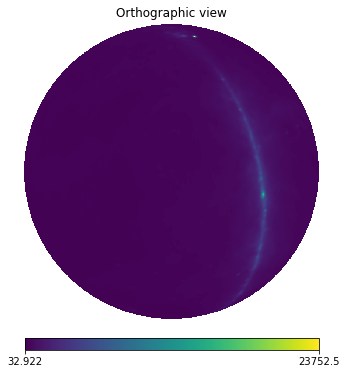

In [3]:
pmap = eda.generate_gsm()

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
eda.plot_image()

plt.subplot(1,2,2)
plt.imshow(pmap[::-1])
plt.close()

/Users/dancpr/Data/blink/ant_array.py:335: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img), extent=(-1, 1, 1, -1), interpolation='none')


/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_23569/2455664891.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(eda.make_image()[::-1, ::-1]))


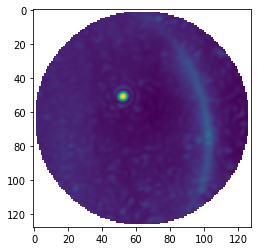

In [5]:
plt.imshow(np.log(eda.make_image()[::-1, ::-1]))

In [37]:
filename_ant = 'test-data/eda2/antenna_locations.txt'
filename_data = 'test-data/eda2/20200209/chan_204_20200209T034646_vis_real.fits'

# Setup array
f_mhz = np.array([159.3750])
lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500
t = Time('2020-02-09T03:46:46.0', format='isot')

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant)
eda.load_fits_data(filename_data)
eda.date = t.datetime


In [33]:
xyz = md['antennas']['xyz']
x, y, z = np.split(xyz, 3, axis=1)
_x, _y, _z = np.split(_a0, 3, axis=1)

In [38]:
eda.xyz

array([[ 0.   ,  0.   ,  0.   ],
       [ 6.727,  5.231, -0.042],
       [-0.367,  3.655, -0.025],
       ...,
       [ 0.   ,  0.   ,  0.   ],
       [ 1.293,  0.738, -0.016],
       [ 0.   ,  0.   ,  0.   ]])

In [5]:
hp.orthview?

Object `hp.orthview` not found.


In [8]:
img = eda.make_image()
#plt.imshow(np.log(img).T)

p = pygdsm.GSMObserver()
p.lat = eda.lat
p.lon = eda.lon
p.date = eda.date
sky = p.generate(eda.f[0]/1e6)
pmap =

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_23569/2125621356.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img)[::-1, ::-1], extent=(-1, 1, 1, -1))
/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_23569/2125621356.py:10: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(pmap)[::-1], extent=(-1, 1, 1, -1))


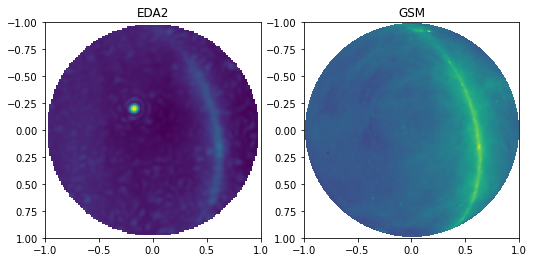

In [14]:
import healpy as hp
pmap = hp.orthview(sky, half_sky=True, return_projected_map=True)

plt.subplot(1,2,1)
plt.title("EDA2")
plt.imshow(np.log(img)[::-1, ::-1], extent=(-1, 1, 1, -1))

plt.subplot(1,2,2)
plt.title("GSM")
plt.imshow(np.log(pmap)[::-1], extent=(-1, 1, 1, -1))

In [3]:
def compute_phase_matrix(w, f, conj=False):
    """ Compute NxN phase weight matrix """
    phs = np.exp(1j * 2 * np.pi * w * f)
    phs = np.conj(phs) if conj else phs
    pmat = np.outer(phs, np.conj(phs))
    return pmat

def test_compute_phase_matrix():
    # Pointing test
    za, az = 0.5, 0.6
    f = 1
    
    # Compute UVW by baseline
    pmat_gold = np.zeros(shape=(256, 256), dtype='complex64')
    uvw = compute_uvw(eda.xyz, za, az)
    phs = np.exp(1j * 2 * np.pi * f * uvw[:, 2])
    a0 = np.array(eda.baselines)[:, 0] - 1
    a1 = np.array(eda.baselines)[:, 1] - 1
    pmat_gold[a0, a1] = phs
    pmat_gold[a1, a0] = np.conj(phs)
    
    # Compute using phase_matrix
    w = uvw[:256, 2]
    pmat = compute_phase_matrix(w, f)
    assert np.allclose(pmat, pmat_gold)

test_compute_phase_matrix()

In [4]:
sin, cos = np.sin, np.cos

def compute_w(xyz, H, d, conjugate=False, in_seconds=True):
    """ Compute geometric delay τ_g, equivalent to w term """
    x, y, z = np.split(xyz, 3, axis=1)
    sh, sd = sin(H), sin(d)
    ch, cd = cos(H), cos(d)
    w  = cd * ch * x - cd * sh * y + sd * z
    w = -w if conjugate else w
    w = w / SPEED_OF_LIGHT if in_seconds else w
    return w.squeeze()

def test_compute_w():
    H, d = 0.5, 0.6
    uvw = compute_uvw(eda.xyz, H, d)
    w_gold = uvw[:, 2]
    w = compute_w(eda.xyz, H, d)
    assert np.allclose(w, w_gold)

test_compute_w()

In [5]:
def generate_phase_matrix(za, az, f, conj=False):
    xyz = eda.xyz[:eda.n_ant]
    w = compute_w(xyz, za, az)
    pmat = compute_phase_matrix(w, f, conj)
    return pmat

In [20]:
eda.a0_baselines

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 6.7270e+00,  5.2310e+00, -4.2000e-02],
       [-3.6700e-01,  3.6550e+00, -2.5000e-02],
       [ 1.1060e+00,  3.9000e+00, -1.3000e-02],
       [ 6.8000e+00,  1.7190e+00, -1.6000e-02],
       [ 4.5770e+00, -4.0270e+00,  1.1000e-02],
       [ 5.5140e+00, -1.1290e+00,  5.0000e-03],
       [ 4.6650e+00,  7.2600e-01, -1.4000e-02],
       [ 2.1370e+00,  1.6930e+00,  3.0000e-03],
       [ 2.1730e+00, -9.7700e-01,  2.2000e-02],
       [ 7.6900e-01, -1.4160e+00,  3.0000e-03],
       [ 3.6050e+00, -1.4020e+00,  1.0000e-02],
       [ 5.3150e+00,  2.0110e+00, -2.0000e-02],
       [ 5.9720e+00,  3.2810e+00, -1.6000e-02],
       [ 3.8910e+00,  3.3320e+00, -2.5000e-02],
       [ 2.7680e+00,  3.1000e-01,  8.0000e-03],
       [ 6.9580e+00, -3.2380e+00,  5.0000e-03],
       [ 7.5520e+00, -1.4880e+00,  2.0000e-03],
       [ 9.2430e+00,  3.9780e+00, -4.1000e-02],
       [ 9.2660e+00,  1.3160e+00, -2.0000e-02],
       [ 1.5029e+01,  1.9100e+00, -5.200

In [6]:
h5_metadata_path = '/Volumes/JIDIJIDI/astro-data/corr_mat_metadata_v4_2020.05.20.h5'
md = h5py.File(h5_metadata_path, 'r')

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant)
eda.load_fits_data(filename_data)
eda.date = t.datetime

_a0 = np.copy(eda.xyz_local)
eda.xyz_local = xyz_celestial

# Create Sun and compute ephemeris
sun  = ephem.Sun()
sun.compute(eda)
za, az = np.pi/2 - sun.alt, sun.az
ra0, dec0 = eda.radec_of(0, np.pi/2)
print(f'SUN \tRA / DEC:  ({sun.ra}, {sun.dec}) \n\tALT / AZ:  ({sun.alt}, {sun.az})')
print(f'ZENITH: ({ra0}, {dec0})')
# Now we have the RA and DEC, need to convert into hour angle
H = ra0 - sun.ra
d = sun.dec
pm = generate_phase_matrix(H, d, eda.f[0], conj=False)

eda.a0_baselines = _a0

eda.data *= pm

NameError: name 'xyz_celestial' is not defined

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_21041/3869457202.py:15: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img).T, extent=(-1, 1, 1, -1))
/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_21041/3869457202.py:19: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(pmap[::-1]), extent=(-1, 1, 1, -1))


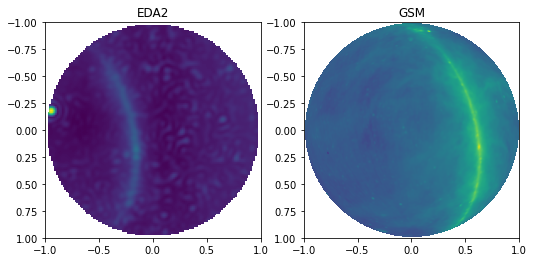

In [19]:
img = eda.make_image()
#plt.imshow(np.log(img).T)

p = pygdsm.GSMObserver()
p.lat = eda.lat
p.lon = eda.lon
p.date = eda.date
sky = p.generate(eda.f[0]/1e6)

import healpy as hp
pmap = hp.orthview(sky, half_sky=True, return_projected_map=True)

plt.subplot(1,2,1)
plt.title("EDA2")
plt.imshow(np.log(img).T, extent=(-1, 1, 1, -1))

plt.subplot(1,2,2)
plt.title("GSM")
plt.imshow(np.log(pmap[::-1]), extent=(-1, 1, 1, -1))

### HDF5 collated

Collation done on nimbus4 in /data/dancpr/post-x-test/

In [95]:
h5_path = '/Volumes/JIDIJIDI/astro-data/corr_mat_chunked_2020.05.20.h5'
h5_metadata_path = '/Volumes/JIDIJIDI/astro-data/corr_mat_metadata_v4_2020.05.20.h5'

h = h5py.File(h5_path, 'r')
md = h5py.File(h5_metadata_path, 'r')
f_mhz = md['freqs'][:]
t = Time(md['time'][0], format='jd')

lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500

eda = RadioArray(lat, lon, elev, f_mhz, filename_ant)
eda.load_h5_data(h5_path)
eda.antennas = md['antennas']['xyz']
eda.xyz       = eda._compute_baseline_vectors()
eda.a0_baselines = eda.xyz[:eda.n_ant]
eda.date = t.datetime


#uvw = md['baselines']['uvw']
#eda.a0_baselines = uvw[:256] * SPEED_OF_LIGHT

#sc = SkyCoord(md['ra'][0], md['dec'][0], unit=('deg', 'deg'))
#sun = make_source('sun', sc.ra.to_string(sep=':'), sc.dec.to_string(sep=':'), flux=1.0, epoch=2000)
#sun_eph = ['sun',sc.ra.to_string(sep=':'), sc.dec.to_string(sep=':'), 1.0] 


# Create Sun and compute ephemeris
print(t.datetime)
sun  = ephem.Sun()
sun.compute(eda)
print(f'SUN \tRA / DEC:  ({sun.ra}, {sun.dec}) \n\tALT / AZ:  ({sun.alt}, {sun.az})')
za, az = np.pi/2 - sun.alt, sun.az

ra0, dec0 = eda.radec_of(0, np.pi/2)
print(ra0, dec0)
# Now we have the RA and DEC, need to convert into hour angle
H = ra0 - sun.ra
d = sun.dec

data = np.copy(eda.data)

2020-05-20 03:43:36.141272
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)


In [119]:
md['time'][1]

2458989.6555109024

0

In [87]:
ra0, dec0 = eda.radec_of(0, np.pi/2)
print(ra0, dec0)
# Now we have the RA and DEC, need to convert into hour angle
H = ra0 - sun.ra
d = sun.dec

3:22:30.09 -26:46:24.0


In [85]:
uvw2 = compute_uvw(eda.xyz, H, d, conjugate=False)

In [27]:
md['baselines']['w'][:]

array([0.0000000e+00, 1.4974933e-08, 8.6605576e-09, ..., 0.0000000e+00,
       2.2128859e-09, 0.0000000e+00], dtype=float32)

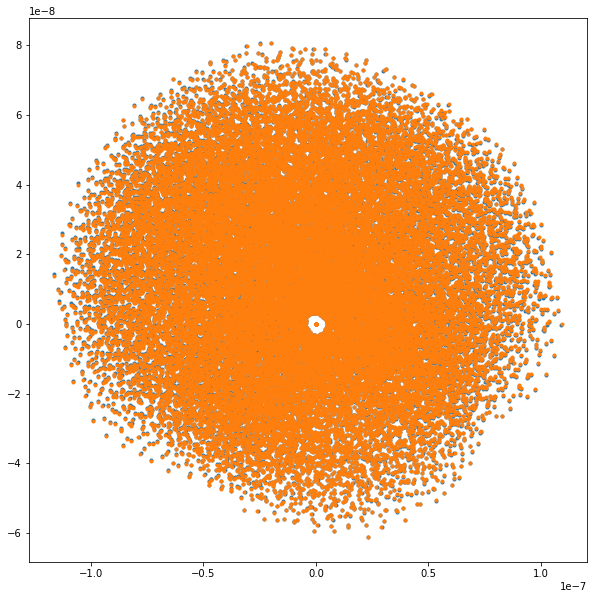

In [86]:
plt.figure(figsize=(10,10))
#plt.scatter(uvw[:, 0], uvw[:,1], marker='.')
plt.scatter(uvw2[:, 0], uvw2[:,1], marker='.')
plt.scatter(md['baselines']['u'][:], md['baselines']['v'][:], marker='.')

/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_12741/442696987.py:7: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img).T)


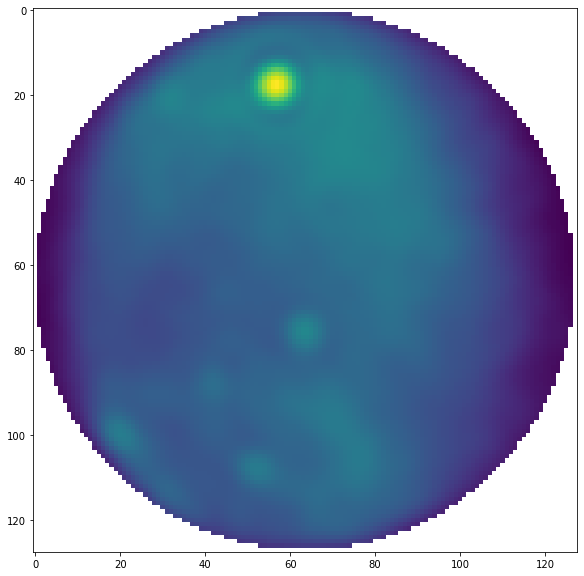

In [103]:
pm = generate_phase_matrix(H, d, eda.f[0], conj=False)

eda.data = np.conj(data) * pm
eda.a0_baselines = eda2.a0_baselines
img = eda.make_image()

plt.figure(figsize=(10, 10))
plt.imshow(np.log(img).T)

In [131]:
datetime.timedelta(seconds=8.5)

datetime.timedelta(seconds=8, microseconds=500000)

In [124]:
plt.figure(figsize=(10,10))

for ii in range(1000):
    print(ii)
    eda.set_freq(ii)
    if ii % 32 == 0:
        eda.date =  Time(md['time'][ii//32], format='jd').datetime + datetime.timedelta(seconds=8.5)
        sun.compute(eda)
        print(f'SUN \tRA / DEC:  ({sun.ra}, {sun.dec}) \n\tALT / AZ:  ({sun.alt}, {sun.az})')
        za, az = np.pi/2 - sun.alt, sun.az

        ra0, dec0 = eda.radec_of(0, np.pi/2)
        print(f'ZENITH: ({ra0}, {dec0})')
        # Now we have the RA and DEC, need to convert into hour angle
        H = ra0 - sun.ra
        d = sun.dec
        pm = generate_phase_matrix(H, d, eda.f[0], conj=False)
    eda.data = np.conj(eda.data) * pm
    img = eda.make_image()

    plt.imshow(np.log(img).T)
    plt.savefig(f"img/eda-{ii}.png")
    plt.clf()

0
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)


/var/folders/n3/pbwrsp713bd28_l4xt61c7zh0000gn/T/ipykernel_12741/600427129.py:20: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img).T)


1
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
2
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
3
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
4
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
5
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
6
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
7
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
8
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
9
SUN 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: 

<Figure size 720x720 with 0 Axes>

masked_array(data=[11.506254838805603, --, --, ..., --, --,
                   12.266727710696154],
             mask=[False,  True,  True, ...,  True,  True, False],
       fill_value=-1.6375e+30)

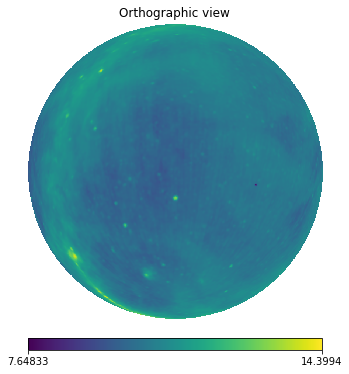

In [113]:
import pygdsm
p = pygdsm.GSMObserver()
p.lat = eda.lat
p.lon = eda.lon
p.date = eda.date
p.generate(eda.f[0]/1e6)
p.view(logged=True)

In [390]:
pixvals = []
for ii in range(0, 11000, 100):
    eda.set_freq(ii)
    grid = eda.make_image(128)
    pixvals.append([grid[64,64], grid[64, 70]])
    print(ii)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900


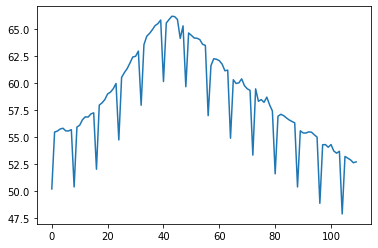

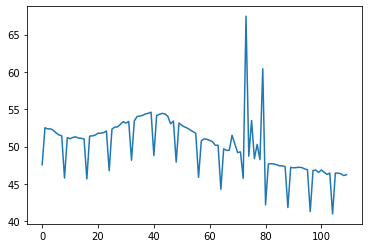

In [393]:
pixvals = np.array(pixvals)
plt.plot(10*np.log10(pixvals[:, 0]))
plt.figure()
plt.plot(10*np.log10(pixvals[:, 1]))

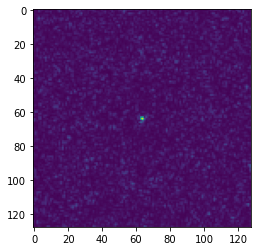

In [395]:
plt.imshow(np.log(grid))

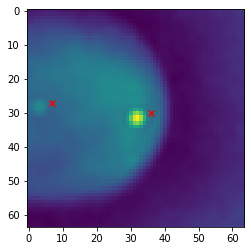

In [333]:
eda.set_freq(0)
plt.figure(figsize=(4,4))
grid = eda.make_image(64)
plt.imshow(np.log(grid))
plt.scatter(x=7, y=27, c='red', marker='x')
plt.scatter(x=36, y=30, c='red', marker='x')

In [27]:
freq0_mhz = pix0[3].MHz
date0_jd  = a[0].data['DATE'][0]

Δf = a[0].header['CDELT4']

In [63]:
import h5py

In [64]:
h = h5py.File(, 'r')

In [66]:
d = h['data']
d

<HDF5 dataset "data": shape (11200, 256, 256, 4), type "<c8">

/Users/dancpr/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


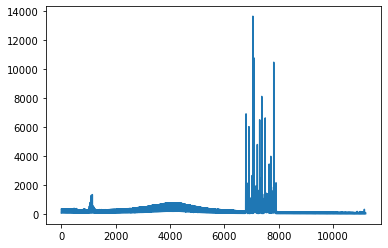

In [67]:
plt.plot(d[:, 0, 0, 0])

In [306]:
P_on / P_off

1.0583230072641503

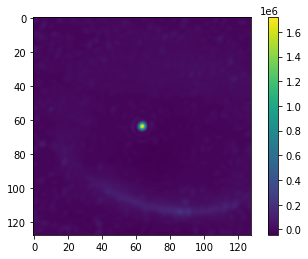

In [314]:
plt.imshow(S_h)
plt.colorbar()

(42.93800541147864, 12.979373028926618)

In [323]:
S_vis[114, 86]

214159.6549772892

In [385]:
P_all = grid
P_vis = grid - np.abs(P_inc)

## Assiming a cos**2 beam
T_gc  = 16500 * np.cos(np.deg2rad(70))
T_sun = 50000 ## Jy

P_vis_gc  = P_vis[114, 86]
P_vis_sun = P_vis[64, 64]

P_all_gc  = P_all[114, 86]
P_all_sun = P_all[64, 64]

α_vis = T_sun / P_vis_sun 
α_all = T_sun / P_all_sun 

S_vis = α_vis * P_vis

In [386]:
S = np.abs(α_all * P_inc)
S

5856.153556063544277

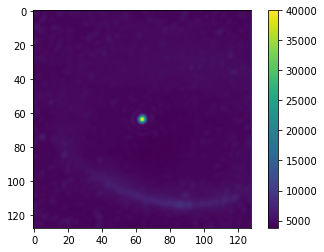

In [375]:
S = α_all * P_inc + α_all/α_vis * S_vis
plt.imshow(np.abs(S))
plt.colorbar()

masked_array(data=[168.70313755915225, --, --, ..., --, --,
                   271.1864086462837],
             mask=[False,  True,  True, ...,  True,  True, False],
       fill_value=-1.6375e+30)

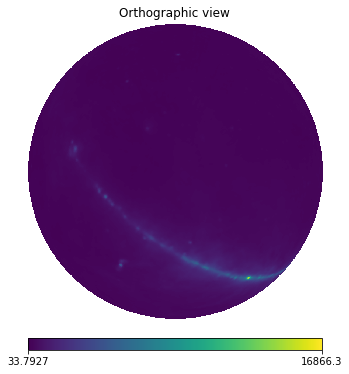

In [115]:
eda.radec_of(0, 0)

(2.419237538971867, 0.017635529856064525)

'57:06:26.712'

Ephemeris Date: 2022/11/7 16:36:56
SRC          RA           DEC        ALT          AZ
sun          9:07:43.86  19:54:38.7  -19:33:05.0  358:02:03.1
